In [1]:
import torch
import numpy as np
import gym
from collections import deque, namedtuple
import random
from matplotlib import pyplot as plt
import numpy as np

In [2]:
tt = torch.tensor
# torch.autograd.set_detect_anomaly(True)

In [3]:
ReplayBufferItem = namedtuple('ReplayBufferItem', ['state', 'action', 'reward', 'next_state', 'done'])
class ReplayBuffer:
    def __init__(self, capacity) -> None:
        self.memory = deque(maxlen=capacity)

    def append(self, *args) -> None:
        self.memory.append(ReplayBufferItem(*args))

    def sample(self, batch_size) -> list:
        return random.sample(self.memory, batch_size)
    
    def sample_reshaped(self, batch_size) -> list:
        # convert list of tuples to tuple of lists
        return zip(*self.sample(batch_size))
    
    def __len__(self) -> int:
        return len(self.memory)

In [4]:
class Critic(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers1, self.layers2 = self._build_network(dims)

    def _build_network(self, dims):
        layers1 = []
        layers2 = []
        for i in range(len(dims)-1):
            layers1.append(torch.nn.Linear(dims[i], dims[i+1]))
            layers2.append(torch.nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:
                layers1.append(torch.nn.ReLU())
                layers2.append(torch.nn.ReLU())
        return torch.nn.Sequential(*layers1), torch.nn.Sequential(*layers2)
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        return self.layers1(x), self.layers2(x)

In [5]:
class Actor(torch.nn.Module):
    def __init__(self, dims, action_scale=None, action_bias=None):
        super().__init__()
        self.layers = torch.nn.Sequential()
        
        for i in range(len(dims)-2):
            self.layers.append(torch.nn.Linear(dims[i], dims[i+1]))
            if i != len(dims)-2:
                self.layers.append(torch.nn.ReLU())

        self.mu_layer = torch.nn.Linear(dims[-2], dims[-1])
        self.sigma_layer = torch.nn.Linear(dims[-2], dims[-1])
        
        self.action_scale = action_scale or torch.tensor(1.0)
        self.action_bias = action_bias or torch.tensor(0.0)
            
    def sample(self, x):
        mus, sigmas = self.forward(x)
        sigmas = torch.exp(sigmas)
        action = torch.distributions.Normal(mus, sigmas).sample()
        action = torch.tanh(action) * self.action_scale + self.action_bias
        return action

    def sample_with_log_prob(self, x):
        mus, sigmas = self.forward(x)
        sigmas = torch.exp(sigmas)
        probs = torch.distributions.Normal(mus, sigmas)
        action = probs.rsample()
        log_prob = probs.log_prob(action).sum(axis=-1)

        # Adjusting for the tanh squashing function
        log_prob -= (2 * (np.log(2) - action - torch.nn.functional.softplus(-2 * action))).sum(axis=-1)

        action = torch.tanh(action) * self.action_scale + self.action_bias

        return action, log_prob
           
    def forward(self, x):
        mid = self.layers(x)
        mus = self.mu_layer(mid)
        sigmas = self.sigma_layer(mid)
        sigmas = torch.clamp(sigmas, min=-20, max=2)
        return mus, sigmas

In [6]:
class SAC:
    def __init__(self, env):
        
        input_size = env.observation_space.shape[0]
        output_size = env.action_space.shape[0]
        policy_hidden_dim = [32, 32]
        q_hidden_dim = [32, 32]        
        
        self.policy_net_dims = [input_size, *policy_hidden_dim, output_size]
        self.critic_net_dims = [input_size + output_size, *q_hidden_dim, 1]
                
        self.gamma = 0.95
        self.batch_size = 128
        self.polyak = 0.995

        self.target_entropy = -np.prod(env.action_space.shape).item()  # Usually -dim(A)
        self.log_alpha = torch.tensor(np.log(0.2)).requires_grad_(True)
        
        self.env = env
        self.replay_buffer = ReplayBuffer(100000)
        self.policy = Actor(self.policy_net_dims)
        self.critic = Critic(self.critic_net_dims)
        self.critic_t = Critic(self.critic_net_dims)
        
        self.critic_t.load_state_dict(self.critic.state_dict())
        
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=1e-3)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=1e-4)
    
    def train(self, epochs):
        state, info = self.env.reset()
        state = tt(state, dtype=torch.float32)
        r = 0
        step = 0
        scores = []
        losses = []
        for epoch in range(epochs):
            
            # gather experience
            action = self.policy.sample(state)
            
            next_state, reward, done, trunc, info = self.env.step(action.detach().numpy())
            next_state, reward, done = tt(next_state, dtype=torch.float32), tt(reward, dtype=torch.float32), tt(done)
            r += reward
            step += 1
            
            self.replay_buffer.append(state, action, reward, next_state, done)
            if len(self.replay_buffer) > self.batch_size:
                # sample from buffer
                states, actions, rewards, next_states, dones = self.replay_buffer.sample_reshaped(self.batch_size)
                states = torch.stack(states, dim=0)
                actions = torch.stack(actions, dim=0).reshape(-1, 1)
                rewards = torch.stack(rewards, dim=0).reshape(-1, 1)
                next_states = torch.stack(next_states, dim=0)
                dones = torch.stack(dones, dim=0).reshape(-1, 1)
                # update critic 1
                
                next_actions, next_log_prob = self.policy.sample_with_log_prob(next_states)                    
                q1tv, q2tv = self.critic_t(next_states, next_actions)
                target = rewards + self.gamma * (~dones) * torch.min(q1tv, q2tv) - self.log_alpha.exp() * next_log_prob
                target = target.detach()
                
                q1v, q2v = self.critic(states, actions)
                q1_loss = torch.nn.MSELoss()(q1v, target)
                q2_loss = torch.nn.MSELoss()(q2v, target)
                
                critic_loss = q1_loss + q2_loss
                
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                
                # update policy
                now_actions, now_log_prob = self.policy.sample_with_log_prob(next_states)                
                q1v, q2v = self.critic(states, now_actions)
                
                policy_loss = torch.mean(self.log_alpha.exp() * now_log_prob - torch.min(q1v, q2v))
                
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()
                
                # update alpha
                alpha_before = self.log_alpha.detach()
                alpha_loss = -torch.mean(self.log_alpha * (now_log_prob + self.target_entropy).detach())
                self.alpha_optimizer.zero_grad()
                alpha_loss.backward()
                self.alpha_optimizer.step()
                
                losses.append([q1_loss.item(), q2_loss.item(), policy_loss.item(), alpha_loss.item()])
                
                # update target networks using polyak averaging
                for target_param, param in zip(self.critic_t.parameters(), self.critic.parameters()):
                    target_param.data.copy_(target_param.data * (1.0 - self.polyak) + param.data * self.polyak)
                    

            if done or trunc:
                state, info = self.env.reset()
                state = tt(state, dtype=torch.float32)
                print("Epoch: {}, Reward: {}".format(epoch+1, r))
                scores.append(r)
                r = 0
        
        return scores, losses
            
            

In [7]:
sac = SAC(gym.make('Pendulum-v1'))
scores, losses = sac.train(50000)

d:\Assignment\Year_4\70028\rl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\Assignment\Year_4\70028\rl\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 200, Reward: -991.7847900390625
Epoch: 400, Reward: -1273.76904296875
Epoch: 600, Reward: -1723.4686279296875
Epoch: 800, Reward: -1130.67431640625
Epoch: 1000, Reward: -1386.4549560546875
Epoch: 1200, Reward: -1329.9560546875
Epoch: 1400, Reward: -1317.0980224609375
Epoch: 1600, Reward: -1081.7423095703125
Epoch: 1800, Reward: -1643.6361083984375
Epoch: 2000, Reward: -1329.6513671875
Epoch: 2200, Reward: -1725.238037109375
Epoch: 2400, Reward: -1676.828125
Epoch: 2600, Reward: -1597.1986083984375
Epoch: 2800, Reward: -1589.9007568359375
Epoch: 3000, Reward: -1506.9244384765625
Epoch: 3200, Reward: -1512.209716796875
Epoch: 3400, Reward: -1733.1556396484375
Epoch: 3600, Reward: -948.6337280273438
Epoch: 3800, Reward: -1386.9820556640625
Epoch: 4000, Reward: -1338.160400390625
Epoch: 4200, Reward: -1386.006591796875
Epoch: 4400, Reward: -1290.86962890625
Epoch: 4600, Reward: -1414.2772216796875
Epoch: 4800, Reward: -1670.1953125
Epoch: 5000, Reward: -1612.7308349609375
Epoch: 520

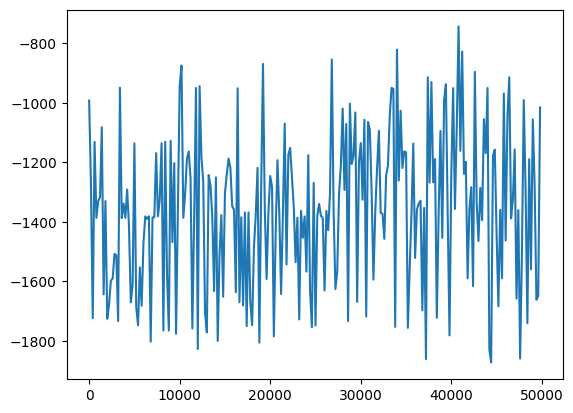

In [14]:
plt.plot(list(range(0, len(scores) * 200, 200)), scores)

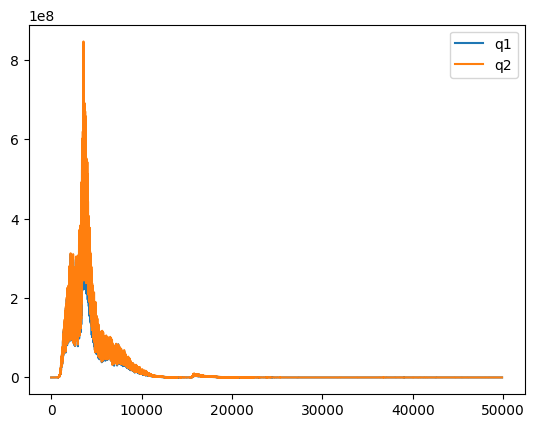

In [15]:
plt.plot(list([l[0], l[1]] for l in losses))
plt.legend(['q1', 'q2'])

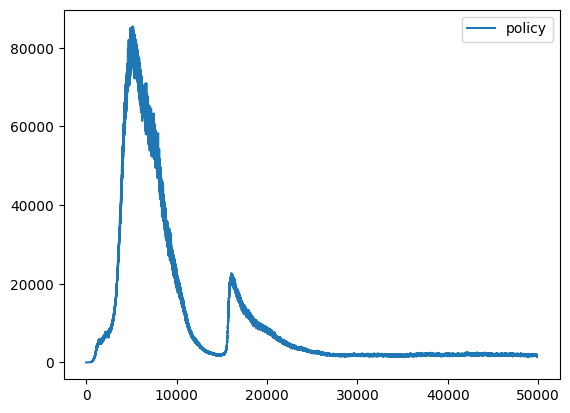

In [16]:
plt.plot([l[2] for l in losses])
plt.legend(['policy'])

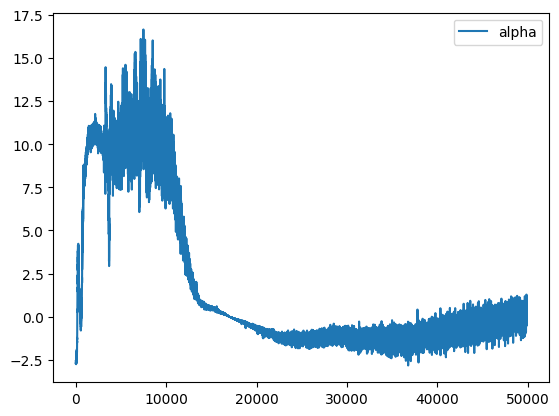

In [17]:
plt.plot([l[3] for l in losses])
plt.legend(['alpha'])